In [1]:
# Download the models

import os
import pathlib


if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2591, done.
remote: Counting objects: 100% (2591/2591), done.
remote: Compressing objects: 100% (2256/2256), done.
remote: Total 2591 (delta 505), reused 1445 (delta 298), pack-reused 0
Receiving objects: 100% (2591/2591), 124.11 MiB | 11.93 MiB/s, done.
Resolving deltas: 100% (505/505), done.
Checking out files: 100% (2500/2500), done.


In [0]:
# Compile protobufs and install the object_detection package

In [0]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.

In [4]:
%%bash 
cd models/research
pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1017522 sha256=39bb26236bc9113d27c72253a37b14f2cbe5b12247c30b564566cc1e716c3466
  Stored in directory: /tmp/pip-ephem-wheel-cache-o37n7oxn/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
Successfully built object-detection


In [0]:
import os
import sys
import tarfile
import zipfile

import numpy as np
import tensorflow as tf
import six.moves.urllib as urllib


from PIL import Image
from io import StringIO
from IPython.display import display
from collections import defaultdict
from matplotlib import pyplot as plt

In [0]:
# Get helper funcs from object_detection module

from object_detection.utils import label_map_util
from object_detection.utils import ops as utils_ops
from object_detection.utils import visualization_utils as vis_util

In [0]:
# Patches

# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

In [0]:
from tensorflow.keras.models import load_model 
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config = config)

## Prepare Model

In [0]:
# Load Model

def load_model(model_name):
  base_url = 'http://download.tensorflow.org/models/object_detection/'
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(
    fname = model_name, 
    origin = base_url + model_file,
    untar = True)

  model_dir = pathlib.Path(model_dir)/"saved_model"

  model = tf.saved_model.load(str(model_dir))
  model = model.signatures['serving_default']

  return model

In [0]:
# List of the strings that is used to add correct label for each box.

PATH_TO_LABELS = 'models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name = True)

In [11]:
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.

PATH_TO_TEST_IMAGES_DIR = pathlib.Path('models/research/object_detection/test_images')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
TEST_IMAGE_PATHS

[PosixPath('models/research/object_detection/test_images/image1.jpg'),
 PosixPath('models/research/object_detection/test_images/image2.jpg')]

## Detection

In [12]:
model_name = 'ssd_mobilenet_v1_coco_2017_11_17'
detection_model = load_model(model_name)

76537856/76534733 [==============================] - 1s 0us/step
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [13]:
print(detection_model.inputs)

[<tf.Tensor 'image_tensor:0' shape=(None, None, None, 3) dtype=uint8>]


In [14]:
detection_model.output_dtypes

{'detection_boxes': tf.float32,
 'detection_classes': tf.float32,
 'detection_scores': tf.float32,
 'num_detections': tf.float32}

In [15]:
detection_model.output_shapes

{'detection_boxes': TensorShape([None, 100, 4]),
 'detection_classes': TensorShape([None, 100]),
 'detection_scores': TensorShape([None, 100]),
 'num_detections': TensorShape([None])}

In [0]:
# wrapper around preds

def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  output_dict = model(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

In [0]:
def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks = output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates = True,
      line_thickness = 8)

  display(Image.fromarray(image_np))

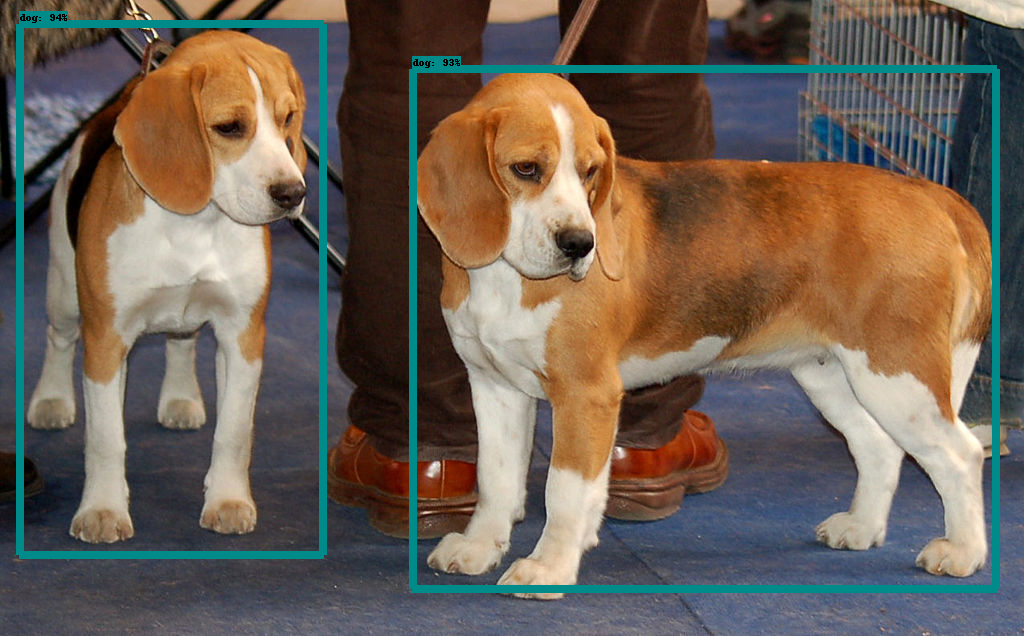

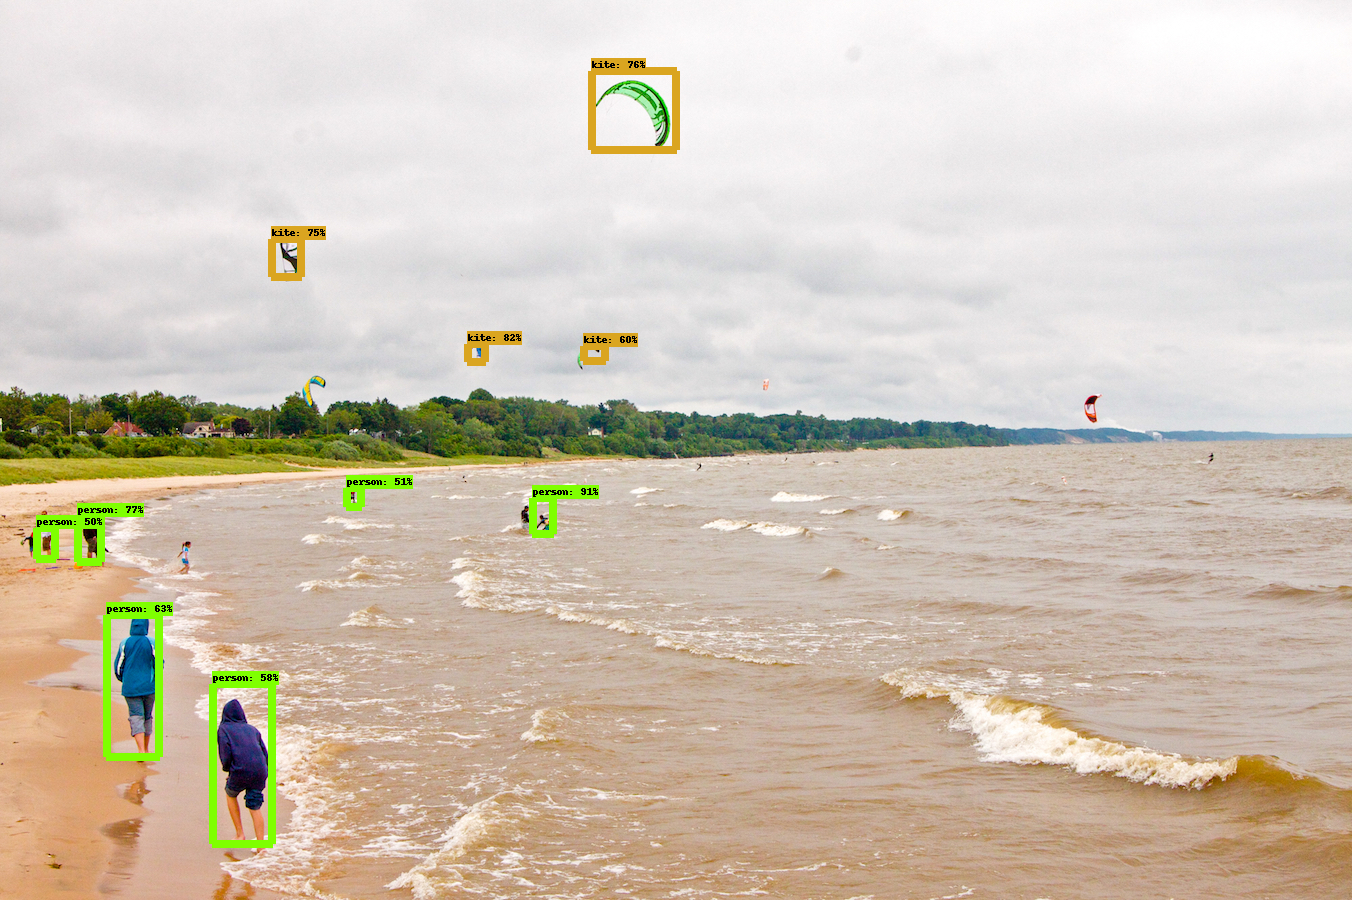

In [18]:
for image_path in TEST_IMAGE_PATHS:
  show_inference(detection_model, image_path)

## Instance Segmentation

In [19]:
masking_model = load_model("mask_rcnn_inception_resnet_v2_atrous_coco_2018_01_28")

727392256/727390102 [==============================] - 11s 0us/step
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [20]:
masking_model.output_shapes

{'detection_boxes': TensorShape([None, 100, 4]),
 'detection_classes': TensorShape([None, 100]),
 'detection_masks': TensorShape([None, None, None, None]),
 'detection_scores': TensorShape([None, 100]),
 'num_detections': TensorShape([None])}

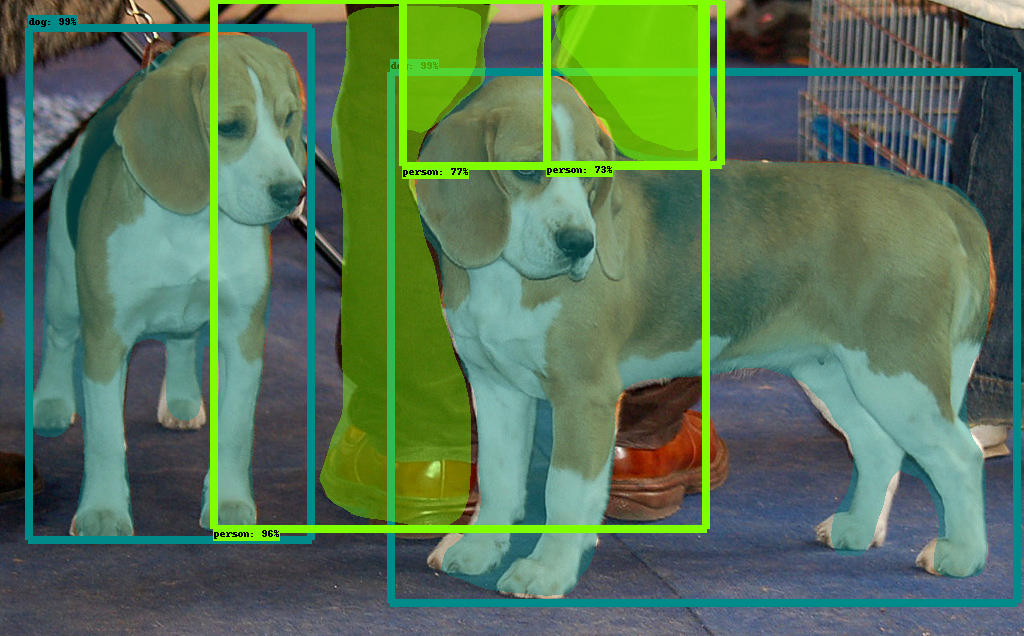

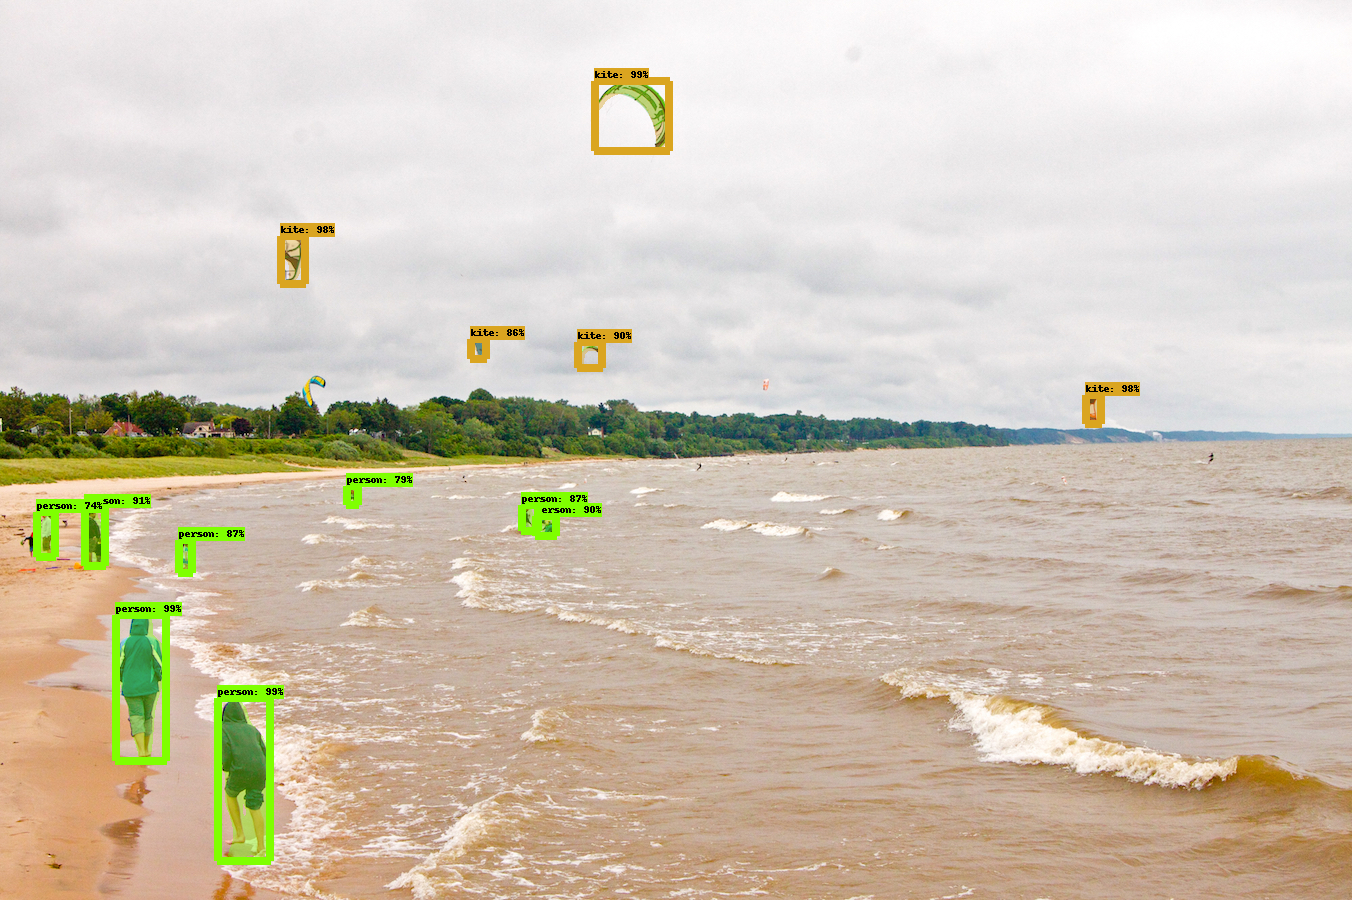

In [21]:
for image_path in TEST_IMAGE_PATHS:
  show_inference(masking_model, image_path)